In [31]:
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
import matplotlib.pyplot as plt
import cv2

# from mobilenet_v1.mobilenet import MobileNet
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

## Loading and initialising the factors and samples

In [12]:
data = h5py.File('./3dshapes.h5', 'r')

images = data['images']
labels = data['labels']
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

## Methods for sampling unconditionally/conditionally on a given factor

In [13]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
  """ Converts factors to indices in range(num_data)
  Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

  Returns:
    indices: np array shape [batch_size].
  """

  indices = 0
  base = 1
  for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
    indices += factors[factor] * base
    base *= _NUM_VALUES_PER_FACTOR[name]
  return indices


def sample_random_batch(batch_size):
  """ Samples a random batch of images.
  Args:
    batch_size: number of images to sample.

  Returns:
    batch: images shape [batch_size,64,64,3].
  """

  indices = np.random.choice(n_samples, batch_size)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])


def sample_batch(batch_size, fixed_factor, fixed_factor_value):
  """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
  """

  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  factors[fixed_factor] = fixed_factor_value
  indices = get_index(factors)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])

In [14]:
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

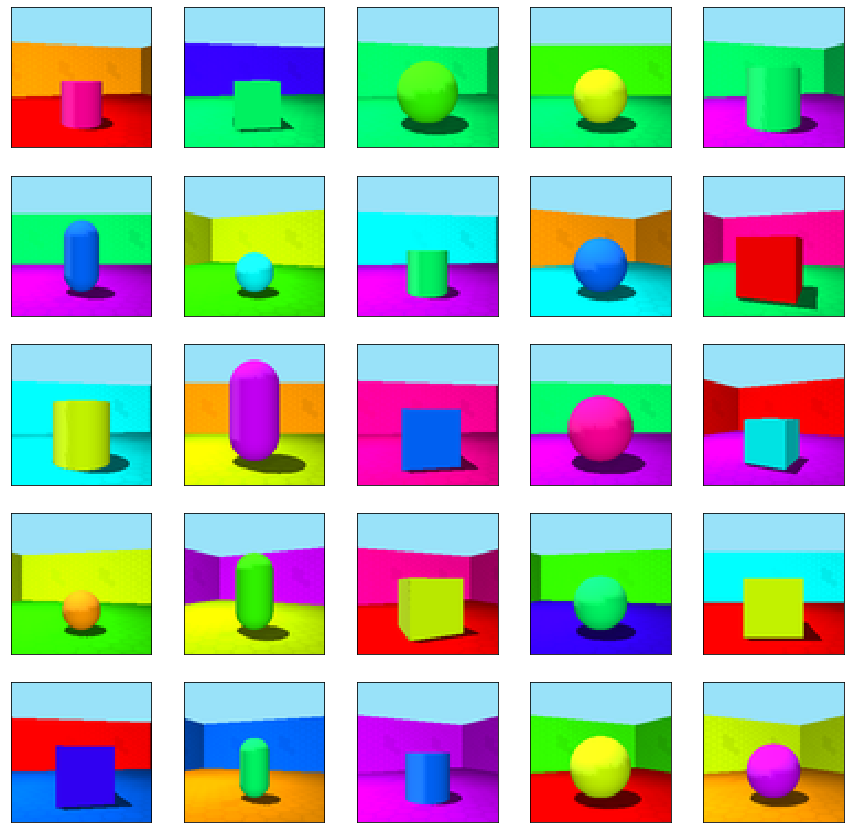

In [15]:
batch_size = 25
img_batch = sample_random_batch(batch_size)

show_images_grid(img_batch)

In [21]:
print(label_shape)

(6,)


## Preprocessing the images from the 'data'

In [ ]:
def img_proc(file):
    img = image.load_img(img_path + file, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_arr = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

## Defining the architecture of the Model

In [35]:
# Using MobileNetv1
IMAGE_SIZE = 224
ALPHA=0.75
EPOCHS=20

base_model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), include_top = False, 
                     weights = "imagenet", classes = 4)

17235968/17225924 [==============================] - 7s 0us/step


In [42]:
def model_architecture(base_model, dropout, fc_layers, classes):
    
    # Freezing the layers
    for layers in base_model.layers:
        layers.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    for fc in fc_layers:
        # new FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # new softmax layer
    predictions = Dense(classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [46]:
FC_LAYERS = [100, 50]
dropout = 0.5

finetune_model = model_architecture(base_model, dropout=dropout, fc_layers=FC_LAYERS, classes=4)

In [47]:
finetune_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [52]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

# train_generator=train_datagen.flow_from_directory('3D_Shapes_Dataset',
#                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                                  color_mode='rgb',
#                                                  batch_size=32,
#                                                  class_mode='categorical', shuffle=True)

In [54]:

finetune_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# step_size_train=train_generator.n//train_generator.batch_size

# history = finetune_model.fit_generator(generator=train_generator,
#                                        steps_per_epoch=step_size_train,
#                                        epochs=EPOCHS, 
#                                        shuffle=True)


# history = finetune_model.fit(image, 
#                              labels, 
#                              batch_size=32, 
#                              epochs=EPOCHS, 
#                             shuffle=True)